In [5]:
import pygmt
import os, glob, pickle
import numpy as np


In [25]:
pygmt.config(FONT_ANNOT_PRIMARY = '10p,Times-Roman',
            FONT_LABEL = '8',
            MAP_LABEL_OFFSET = '4p',
            MAP_TICK_LENGTH_PRIMARY = '5p',
#             PS_MEDIA ='A4',
            PROJ_LENGTH_UNIT = 'c',
            MAP_ANNOT_OFFSET_PRIMARY = '5p',
            MAP_ANNOT_OFFSET_SECONDARY = '5p',
            MAP_FRAME_TYPE = 'fancy',
            MAP_FRAME_WIDTH = 'auto',
            FORMAT_GEO_MAP = 'D',
            PS_CHAR_ENCODING = 'Standard+',
            MAP_FRAME_PEN = '2p,black')


def PygmtBegin(figmap, region):
#     grid = pygmt.datasets.load_earth_relief(resolution="30s", region=region)
    pygmt.makecpt(cmap="elevation", series=[0, 4000, 500],output = 'eleva.cpt', continuous=True)
    figmap.basemap(region=region, projection="M15c", frame = ['x1f0.5', 'y1f0.5', 'nSeW'])
    figmap.grdimage('@earth_relief_30s',region =region, cmap="eleva.cpt",monochrome=True, shading=True, transparency=50)
    figmap.coast(resolution = 'h', shorelines ='1/thinnest,black', water='white', borders = '1/0.25p')
    
def FresnelZone(vel=4, depth=100, freq=0.06):
    return np.sqrt(vel*depth/2/freq)

In [44]:
PKLpath = '/Volumes/home/Research/STEP/01_Split'
DATApath = '/Volumes/home/Research/STEP/02_Station_result_csv/2010-2020_*_classify'
method = 'SC'

IU.GNI


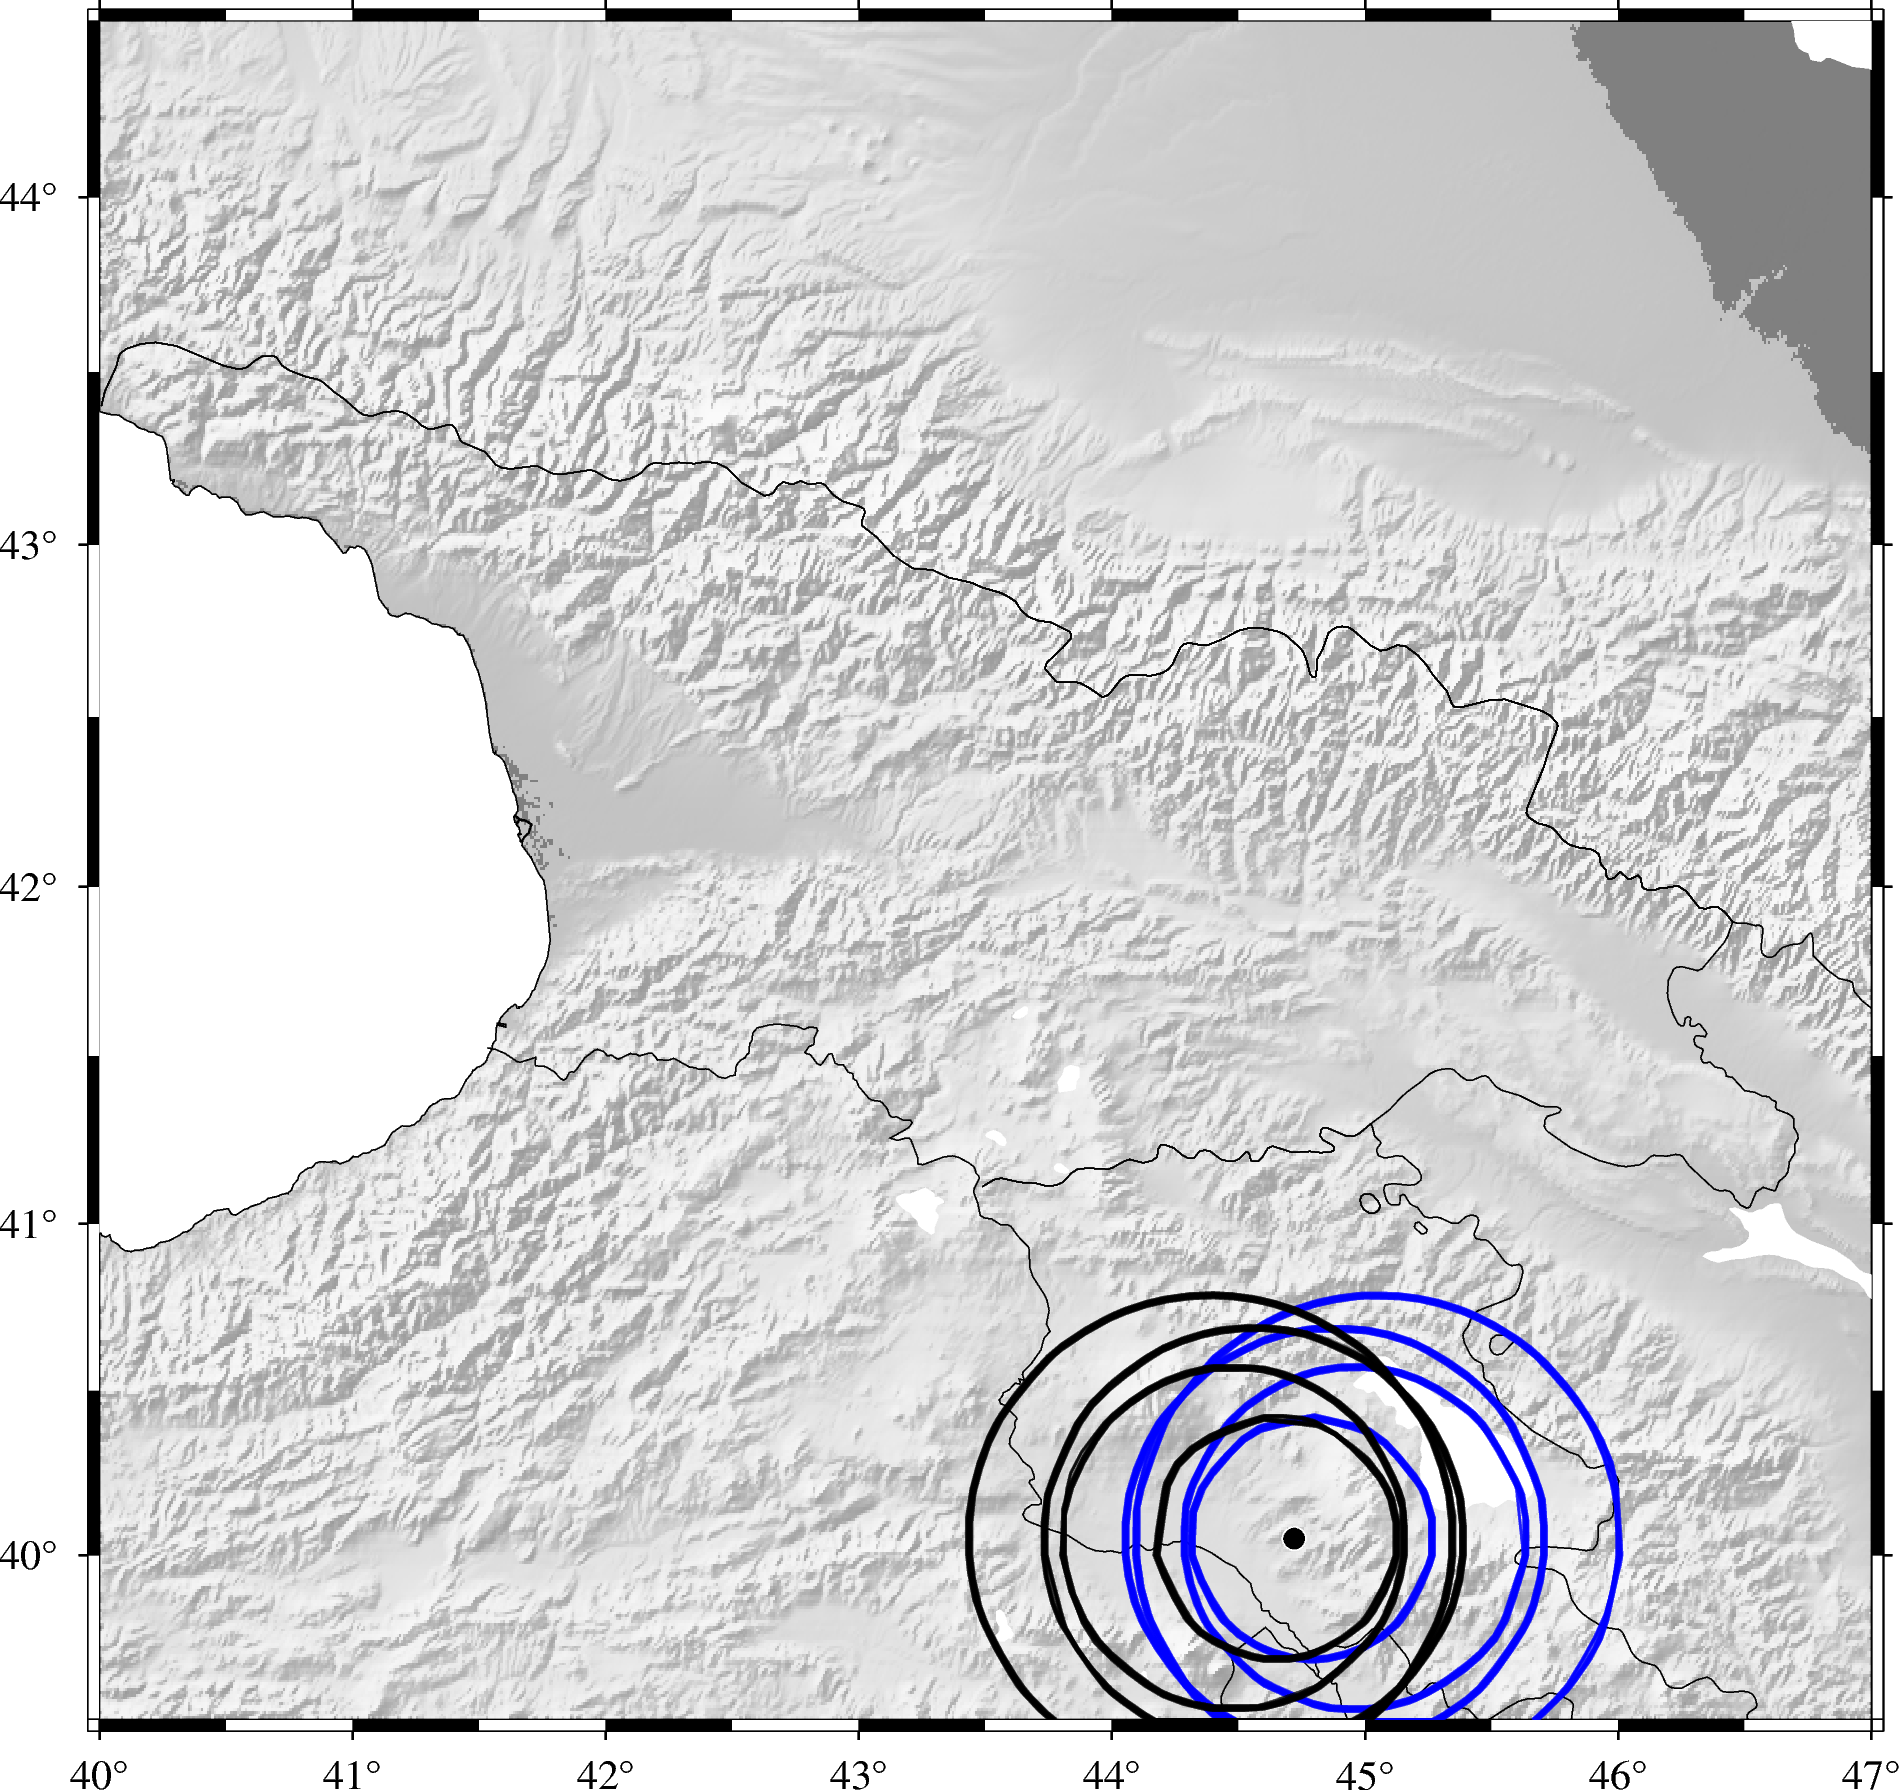

In [56]:
regvals = [40, 47, 39.5, 44.5]
figmap = pygmt.Figure()
PygmtBegin(figmap, regvals)

for pkl in sorted(glob.glob(f'{PKLpath}/IU*.pkl')):
    STApkl = pickle.load(open(pkl, "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    net = values['network']; sta = values['station']
    st_lat = values['latitude']; st_lon = values['longitude']
    
    print(f'{net}.{sta}')
    figmap.plot(x=st_lon, y=st_lat, style="c0.2c",color='black', pen="white") 
    
    for baz in [90,270]:
        if baz == 90: color='blue'
        else: color = 'black'
        cmd = """
        taup pierce -mod iasp91 -h 100 -deg 120 -sta %(st_lat)f %(st_lon)f -baz %(baz)f -ph SKS --pierce 50,100,150,200 -nodiscon  > temp.txt
        """ % locals()
        os.system(cmd)

        cmd = """
        cat temp.txt | awk 'NR>4 {print$4, $5}'
        """ % locals()
        p = os.popen(cmd)
        text = str(p.read())
        p.close()
        diff_dep = text.rsplit('\n')
        for i, dep in enumerate([200,100,150,50]):
            latlon = diff_dep[i]
            p_lat=float(latlon.rsplit(' ')[0])
            p_lon=float(latlon.rsplit(' ')[1])

            !gmt grdmath -I0.2 $p_lon $p_lat -Rg SDIST = temp.nc

            radius = FresnelZone(vel=4, depth=dep, freq=0.06)

            figmap.grdcontour(grid='temp.nc',limit=[radius-1,radius+1],resample=2,pen=f'0.5p,{color}@50',annotation='-')

            os.system('rm -f temp.nc')
        os.system('rm -f temp.txt')

    
figmap.show()
